# Credit Risk Modelling: Scorecard vs ML Classifiers

## Introduction

This project examines how  traditional approaches to building scorecards and credit risk models compare to machine learning methods with regards performance and other business/operational considerations.  

It starts by going through the process of building a standard scorecard in python, and then goes on toexamine some of the advantages of this methodology. It ends with a comparison to some machine learining methods and discusses how they might be applied in a business context. 

The analysis finds some evidence that machine learning outperforms the standard approach with regards modelling, but is inconclusive with regards whether it offers significant business benefits. 

## Data

Data for this project is taken from the [Kaggle "Home Credit Default Risk Competition"](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction). The dataset we will use contains details of previously successful applicants and an indicator of whether they ultimately defaulted (our target variable). 

I will be looking at how feature engineering and dimensionality reduction can be applied to the balance and payment history datsets  in a subsequent project. 

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore')


#training data
train_raw=pd.read_csv("C:/Users/tomra/Desktop/ml_ipynb/Scorecard/application_train.csv")

In [2]:
dev_data=train_raw

In [3]:
dev_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [4]:
dev_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


We've certainly got plenty of variables to work with. Since the Kaggle project linked above has already done plenty of exploratory analysis we'll get straight into deciding which ones we variables to use for analysis. We would likely use Information Value (detailed below) or some other propogation method to choose our variables if we really wanted to build an optimal model; since this is just for illustration purposes, however, we could do with cutting things down to size early on, so we'll simply correlate everything against our TARGET variable and pick the best 9-10. 

Implenting a complete correlation matrix in a mixed-type dataset with mean turning the binary string types (e.g. those given as Y/N) into binary integers and one-hot encoding the other categoricals. 

In [5]:
# credit/income ratio
dev_data["CRED_RATIO"]=dev_data["AMT_CREDIT"]/dev_data["AMT_INCOME_TOTAL"]

In [6]:
#Table dividing variables into "categorical" and "numeric"

Var_Types=pd.DataFrame(dev_data.select_dtypes(include='object').columns, columns=["Var"])
Var_Types["Type"]="Cat"

Nums=pd.DataFrame(dev_data.select_dtypes(exclude='object').columns, columns=["Var"])
Nums["Type"]="Num"

Var_Types=pd.concat([Var_Types, Nums])

In [7]:
from sklearn.preprocessing import LabelEncoder

#Method for encoding binary data (object-types with 2 unique values)
def encode_binary(data):    

    le = LabelEncoder()
    le_count = 0
    df=data
    # Iterate through the columns
    for col in data:
        if data[col].dtype == 'object':
            # If 2 or fewer unique categories
            if len(list(data[col].unique())) <= 2:
                # Train on the data
                le.fit(data[col])
                # Transform  data
                df[col] = le.transform(data[col])   
                            

                # Keep track of how many columns were label encoded
                le_count += 1
                print(col + " was encoded ")
    print('%d columns were label encoded.' % le_count)
    return df

dev_data=encode_binary(dev_data)

NAME_CONTRACT_TYPE was encoded 
FLAG_OWN_CAR was encoded 
FLAG_OWN_REALTY was encoded 
3 columns were label encoded.


In [8]:
# Updating variable types table with binaries
Var_Types["Type"]=np.where(Var_Types.Var.isin(["NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]), "Binary", Var_Types["Type"])

In [9]:
#takes onehot-encoded (df_dummies) table and original table, returns array of original variables and corresponding encoded variables
def encoder_cols_match(df_dummies, df_original):
    new_columns=np.array(df_dummies.columns[np.isin(np.array(df_dummies.columns), np.array(df_original.columns), invert=True)])

    original_columns=np.array(df_original.columns[np.isin(np.array(df_original.columns), np.array(df_dummies.columns), invert=True)])

    cols_match=np.empty([0, 2],dtype=np.dtype('U100'))

    for x in range(original_columns.shape[0]):

        ind=[i for i,item in enumerate(new_columns) if original_columns[x] in item]
        if ind:

            empty=np.empty([len(ind), 2], dtype=np.dtype('U100'))
            empty[:,0]=original_columns[x]
            empty[:,1]=new_columns[ind]
            cols_match=np.concatenate((cols_match, empty))

        else:
            pass

    return cols_match

dummies=pd.get_dummies(dev_data)
dummies_match=encoder_cols_match(dummies, dev_data)

In [10]:
#Correlations:
corr_matrix=dummies.corr()
corr_frame=pd.DataFrame(corr_matrix["TARGET"])

corr_frame=pd.merge(corr_frame.reset_index(), pd.DataFrame(dummies_match,columns=( "original", "dummy")),
how='left', left_on='index', right_on='dummy' )
corr_frame["Characteristic"]=np.where(corr_frame['original'].isnull(), corr_frame['index'], corr_frame['original'])
corr_frame=corr_frame.rename(columns={'index': 'Attribute'})[["Attribute", "TARGET", "Characteristic"]]
corr_frame=corr_frame.merge(Var_Types, left_on='Characteristic', right_on='Var', how='inner')
corr_frame=corr_frame.sort_values(by="TARGET", ascending=False).reset_index()
corr_frame=corr_frame.drop(columns=["Var", "index"])

Throughout the project, I'll try and stick to Credit Risk terminology and refer to categorical variables as "characteristics" and their values as attributes. 

The ten highest correlates:

In [11]:
corr_frame.head(10)

,Attribute,TARGET,Characteristic,Type
0,TARGET,1.000000,TARGET,Num
1,DAYS_BIRTH,0.078239,DAYS_BIRTH,Num
2,REGION_RATING_CLIENT_W_CITY,0.060893,REGION_RATING_CLIENT_W_CITY,Num
3,REGION_RATING_CLIENT,0.058899,REGION_RATING_CLIENT,Num
4,NAME_INCOME_TYPE_Working,0.057481,NAME_INCOME_TYPE,Cat
5,DAYS_LAST_PHONE_CHANGE,0.055218,DAYS_LAST_PHONE_CHANGE,Num
6,CODE_GENDER_M,0.054713,CODE_GENDER,Cat
7,DAYS_ID_PUBLISH,0.051457,DAYS_ID_PUBLISH,Num
8,REG_CITY_NOT_WORK_CITY,0.050994,REG_CITY_NOT_WORK_CITY,Num
9,NAME_EDUCATION_TYPE_Secondary / secondary special,0.049824,NAME_EDUCATION_TYPE,Cat


10 most negatively valued:

In [12]:
corr_frame.tail(10)

,Attribute,TARGET,Characteristic,Type
234,FLOORSMAX_MEDI,-0.043768,FLOORSMAX_MEDI,Num
235,FLOORSMAX_AVG,-0.044003,FLOORSMAX_AVG,Num
236,DAYS_EMPLOYED,-0.044932,DAYS_EMPLOYED,Num
237,ORGANIZATION_TYPE_XNA,-0.045987,ORGANIZATION_TYPE,Cat
238,NAME_INCOME_TYPE_Pensioner,-0.046209,NAME_INCOME_TYPE,Cat
239,CODE_GENDER_F,-0.054704,CODE_GENDER,Cat
240,NAME_EDUCATION_TYPE_Higher education,-0.056593,NAME_EDUCATION_TYPE,Cat
241,EXT_SOURCE_1,-0.155317,EXT_SOURCE_1,Num
242,EXT_SOURCE_2,-0.160472,EXT_SOURCE_2,Num
243,EXT_SOURCE_3,-0.178919,EXT_SOURCE_3,Num


DAYS_BIRTH, DAYS_EMPLOYED, REGION_RATING_CLIENT_W_CITY, REGION_RATING_CLIENT, NAME_INCOME_TYPE, CODE_GENDER, NAME_EDUCATION_TYPE, and EXT_SOURCE_1/2/3 are all reasonable correlates, so we'll go with these. 

### Binning

A lot of the inspiration for what follows in this project is taken from Naeem [Siddiqi's book](https://pdfs.semanticscholar.org/dd5c/7f59d20d9a00d4c93e3d6a7e9973f3462e7e.pdf) on Credit Risk Scorecards. 

The traditional scorecard method has several elements: there are the WOE/IV tables, giving the relative "importance" of each attribute/characteristic; customer-level "scores", estimating how likely a given applicant is to default in terms of the details given on the application; and there is the model itself, used to predict portfolio outcomes and to inform and validate scores. 

Since scores are at attribute level, we will need to turn our numerical variables into discretely-binned characteristics. Starting with DAYS_BIRTH, we'll covert to years initially in order to make the variable somewhat easier to work with:

missing values:0
min: 21
max: 69


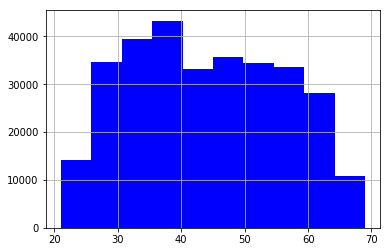

In [13]:
# a function to taking some initial variable checks
def initial_checks(data, var):
    data[var].hist();

    print("missing values:" + str(sum(data[var].isna())))
    print("min: " + str(min(data[var])))
    print("max: " + str(max(data[var])))


dev_data["YEARS_OLD"]=round(dev_data["DAYS_BIRTH"]/-365, 0).apply(int)
initial_checks(dev_data, "YEARS_OLD")

dev_data.YEARS_OLD.hist(color='blue');

We can see we have values in the range of 21 to 69 and no empty values. 

The below will sort any numeric variable into a given number of bins, and also given "na" values their own bin:

In [14]:
def Bad_bins(data, var, tar_var, n_bins):
    
    pd1=data.reset_index().drop(columns=["index"])
    pd1["cats"]=pd.cut(pd1[var], bins=n_bins, precision=1).cat.add_categories("miss").fillna("miss")

    BAD_GOOD=pd.DataFrame(np.array(pd1.groupby("cats").count().reset_index())[:,:2])                 
    BAD_GOOD.columns = ['cats', 'n']

    BAD=pd.DataFrame(pd1[["cats", tar_var]].groupby("cats").sum().rename(columns={tar_var:"bad"}))

    BAD_PER=BAD_GOOD.merge(BAD, left_on="cats", right_index=True)
    BAD_PER=BAD_PER[BAD_PER.n>0]
    BAD_PER["BAD_PER"]=BAD_PER["bad"]/BAD_PER["n"]
  

    ax=BAD_PER.plot(y="BAD_PER", x="cats", kind='bar', color='green')
    ax.set_xlabel(var + " interval")
    ax.set_ylabel("Bad %")
    ax.get_legend().remove()

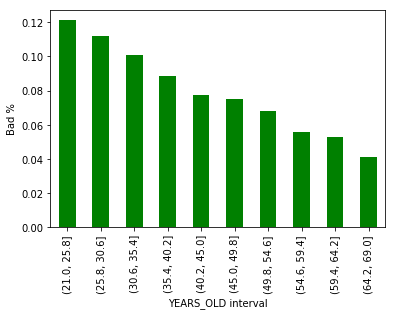

In [15]:
Bad_bins(dev_data, "YEARS_OLD", "TARGET", 10)

We can use this to decide what bins we actually want to use. We can see that the bad rates initially decend in 5-year blocks and then sort of clump, so we will take first 4 as distinct bins, then group the middle 3, the next-to-last-two and 65+:

In [16]:
#a function to apply bins
def apply_bins(data, bounds, var):
  
       for i in range(len(bounds)-1):

            data.loc[(bounds[i]<=data[var]) & (data[var]<bounds[i+1]), var+"_bins"]= str(round(bounds[i], 2))+"_"+str(round(bounds[i+1], 2))


       data.loc[data[var]>=bounds[-1], var+"_bins"] = str(round(bounds[-1],2))+"+"
       data.loc[data[var].isna(), var+"_bins"]="miss"
    
  
age_bounds=[20, 25, 30, 35, 30, 55, 65]

apply_bins(dev_data, age_bounds, "YEARS_OLD")

#We'll keep the data we're going to use in here
IV_WOE_data=pd.DataFrame(np.array([dev_data["YEARS_OLD_bins"], dev_data["TARGET"]]).T)
IV_WOE_data.columns=["YEARS_OLD_bins", "TARGET"]

dev_data=dev_data.drop(columns="YEARS_OLD_bins")

DAYS_EMPLOYED looks to have some anomalies:

missing values:0
min: 0.0
max: 1000.6657534246575


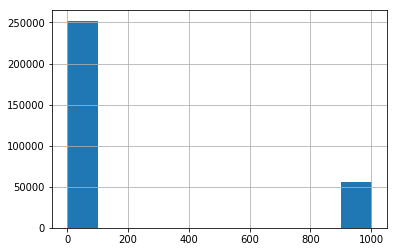

In [17]:
dev_data["YEARS_EMPLOYED"]=abs(dev_data["DAYS_EMPLOYED"]/365)

initial_checks(dev_data, "YEARS_EMPLOYED")

missing values:55374
min: 0.0
max: 49.07397260273972


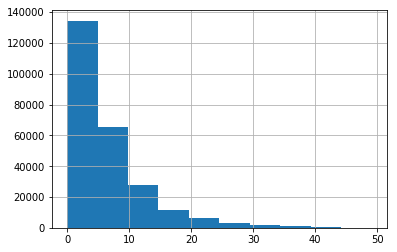

In [18]:
dev_data.loc[dev_data.YEARS_EMPLOYED>100, "YEARS_EMPLOYED"]=float('nan')
initial_checks(dev_data, "YEARS_EMPLOYED")

We've now got some missing values, but we can work with that. Looking at bins:

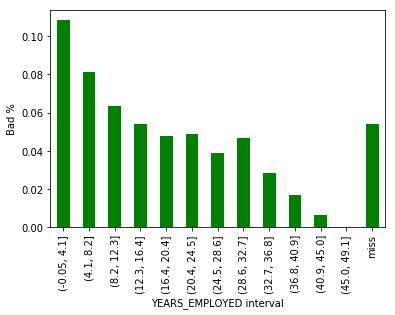

In [19]:
Bad_bins(dev_data, "YEARS_EMPLOYED", "TARGET", 12)

We can see that bad rate doesn't linearly decline in proportion to years employed when binned in this manner.

When the bins become attributes and appear on the scorecard, we want a simple linear relationship between the attribute and score, because this make it easily it easier for customers, operational staff and analysts to understand what the score represents. 

In most cases, we can achieve this by adjusting the bin widths, as below:

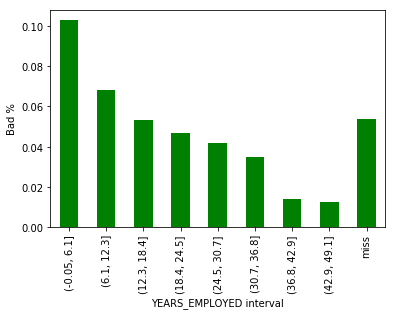

In [20]:
Bad_bins(dev_data, "YEARS_EMPLOYED", "TARGET", 8)

In [21]:
emp_bounds=[0, 5, 10, 20, 30, 40]
apply_bins(dev_data, emp_bounds, "YEARS_EMPLOYED")
IV_WOE_data["YEARS_EMPLOYED_bins"]=dev_data["YEARS_EMPLOYED_bins"]
dev_data=dev_data.drop(columns="YEARS_EMPLOYED_bins")

EXT_SOURCE_1/2/3 appear to be metrics derived from an external credit bureau (hence their predictiveness). Applying categorisation:

missing values:173378
min: 0.014568132412445587
max: 0.962692770561306


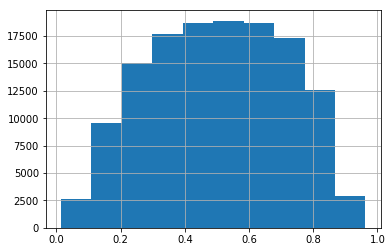

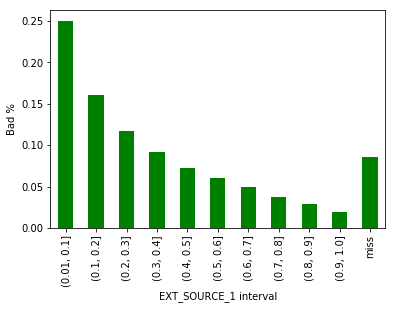

In [22]:
initial_checks(dev_data, "EXT_SOURCE_1")
Bad_bins(dev_data, "EXT_SOURCE_1", "TARGET", 10)

In [23]:
s1_bounds=[x/10 for x in range(11)]
apply_bins(dev_data, s1_bounds, "EXT_SOURCE_1")
IV_WOE_data["EXT_SOURCE_1_bins"]=dev_data["EXT_SOURCE_1_bins"]
dev_data=dev_data.drop(columns="EXT_SOURCE_1_bins")

missing values:660
min: 8.173616518884397e-08
max: 0.8549996664047012


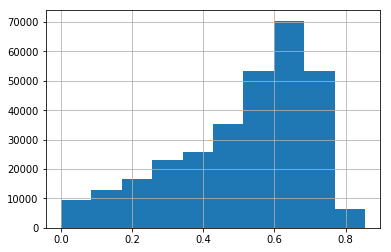

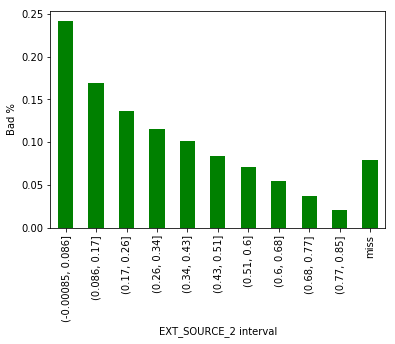

In [24]:
initial_checks(dev_data, "EXT_SOURCE_2")
Bad_bins(dev_data, "EXT_SOURCE_2", "TARGET", 10)

In [25]:
s2_bounds=[x/10 for x in range(10)]
apply_bins(dev_data, s2_bounds, "EXT_SOURCE_2")
IV_WOE_data["EXT_SOURCE_2_bins"]=dev_data["EXT_SOURCE_2_bins"]
dev_data=dev_data.drop(columns="EXT_SOURCE_2_bins")

missing values:60965
min: 0.0005272652387098817
max: 0.8960095494948396


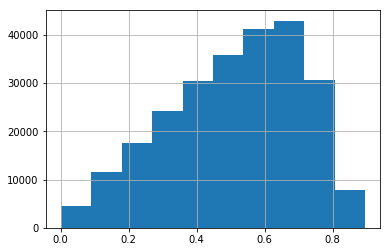

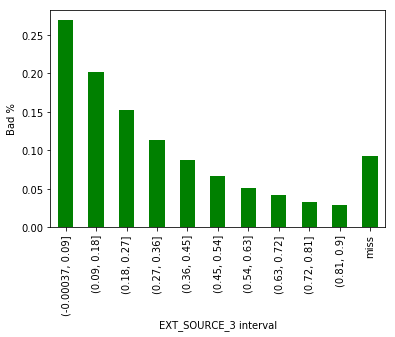

In [26]:
initial_checks(dev_data, "EXT_SOURCE_3")
Bad_bins(dev_data, "EXT_SOURCE_3", "TARGET", 10)

In [27]:
s3_bounds=[x/10 for x in range(10)]
apply_bins(dev_data, s3_bounds, "EXT_SOURCE_3")
IV_WOE_data["EXT_SOURCE_3_bins"]=dev_data["EXT_SOURCE_3_bins"]

That's more or less it for our intial dataset REGION_RATING_CLIENT_W_CITY and REGION_RATING_CLIENT only have 3 unique values, so we'll just convert them to a string - after that we just need to join on the remaining categorical variables:

In [28]:
dev_data.REGION_RATING_CLIENT_W_CITY.unique()

array([2, 1, 3], dtype=int64)

In [29]:
IV_WOE_data["REGION_RATING_CLIENT_W_CITY"]=dev_data.REGION_RATING_CLIENT_W_CITY.apply(str)

In [30]:
dev_data.REGION_RATING_CLIENT.unique()

array([2, 1, 3], dtype=int64)

In [31]:
IV_WOE_data["REGION_RATING_CLIENT"]=dev_data.REGION_RATING_CLIENT.apply(str)

Adding our remaining variables:


In [32]:
var_list=["TARGET", "CODE_GENDER", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE"]

IV_WOE_data[var_list]=dev_data[var_list]
IV_WOE_data=IV_WOE_data.reset_index()

## WOE

Our data now appears as follows:

In [33]:
IV_WOE_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 12 columns):
index                          307511 non-null int64
YEARS_OLD_bins                 307511 non-null object
TARGET                         307511 non-null int64
YEARS_EMPLOYED_bins            307511 non-null object
EXT_SOURCE_1_bins              307511 non-null object
EXT_SOURCE_2_bins              307511 non-null object
EXT_SOURCE_3_bins              307511 non-null object
REGION_RATING_CLIENT_W_CITY    307511 non-null object
REGION_RATING_CLIENT           307511 non-null object
CODE_GENDER                    307511 non-null object
NAME_INCOME_TYPE               307511 non-null object
NAME_EDUCATION_TYPE            307511 non-null object
dtypes: int64(2), object(10)
memory usage: 28.2+ MB


In [34]:
IV_WOE_data.head()

,index,YEARS_OLD_bins,TARGET,YEARS_EMPLOYED_bins,EXT_SOURCE_1_bins,EXT_SOURCE_2_bins,EXT_SOURCE_3_bins,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,CODE_GENDER,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE
0,0,25_30,1,0_5,0.0_0.1,0.2_0.3,0.1_0.2,2,2,M,Working,Secondary / secondary special
1,1,30_55,0,0_5,0.3_0.4,0.6_0.7,miss,1,1,F,State servant,Higher education
2,2,30_55,0,0_5,miss,0.5_0.6,0.7_0.8,2,2,M,Working,Secondary / secondary special
3,3,30_55,0,5_10,miss,0.6_0.7,miss,2,2,F,Working,Secondary / secondary special
4,4,55_65,0,5_10,miss,0.3_0.4,miss,2,2,M,Working,Secondary / secondary special


We are next going to create WOE values. 

WOE stands for "Weight of Evidence" and provides a measure of the predictive power of each characteristic/attribute. 

Our dataset contains a certain number of "Goods" (TARGET==0) and "Bads" (TARGET==1). These are spread across the attributes for each characteristic; if you summed up Goods and Bads by attribute, then each given characteristic's corresponding attributes will contain all of the dataset's Goods and Bads.

For each attribute, you can then take the proportions of the the total dataset Goods and Bads which correspond to that attribute. The ratio of these proportions then gives a measure of the attribute's Good/Bad rates in relation to the dataset's overall Good/Bad rates. If the rates are better than overall, this proportion will be greater than 1, and  will otherwise be between 0 and 1. Taking the log will hence give a positive value for a relatively favourable Good/Bad rate and a negative value for a relatively unfavourable rate. It is then multiplied by 100 for the sake of readability (much like a percentage). 

To derive this we will have to melt the dataset into a long format, so that we have a column of characteristics, a column of attributes and columns of totals corresponding to the attribute: 

In [35]:
IV_WOE=IV_WOE_data.melt(id_vars='index',value_vars=IV_WOE_data.columns[1:], var_name="Characteristic", value_name="Attribute").sort_values(by="index")
IV_WOE=pd.merge(IV_WOE, IV_WOE_data[["index", "TARGET"]], on='index')
IV_WOE["Characteristic"]=IV_WOE["Characteristic"].apply(str)
IV_WOE["Attribute"]=IV_WOE["Attribute"].apply(str)
IV_WOE=IV_WOE[IV_WOE.Characteristic!="TARGET"]
IV_WOE.head(10)

,index,Characteristic,Attribute,TARGET
0,0,YEARS_OLD_bins,25_30,1
1,0,EXT_SOURCE_2_bins,0.2_0.3,1
2,0,REGION_RATING_CLIENT,2,1
4,0,NAME_EDUCATION_TYPE,Secondary / secondary special,1
5,0,NAME_INCOME_TYPE,Working,1
6,0,YEARS_EMPLOYED_bins,0_5,1
7,0,EXT_SOURCE_1_bins,0.0_0.1,1
8,0,CODE_GENDER,M,1
9,0,REGION_RATING_CLIENT_W_CITY,2,1
10,0,EXT_SOURCE_3_bins,0.1_0.2,1


In [36]:
WOE_sum=IV_WOE.groupby(["Characteristic", "Attribute"]).sum().drop(columns='index').reset_index().rename(columns={"TARGET":"BAD"})
WOE_n=IV_WOE.groupby(["Characteristic", "Attribute"]).count().drop(columns='index').reset_index().rename(columns={"TARGET":"Count"})
WOE=pd.merge(WOE_sum, WOE_n[["Attribute", "Characteristic", "Count"]], on=["Attribute", "Characteristic"])
cols=["Characteristic", "Attribute", "Count", "BAD"]
WOE=WOE[cols]
WOE.head(16)

,Characteristic,Attribute,Count,BAD
0,CODE_GENDER,F,202448,14170
1,CODE_GENDER,M,105059,10655
2,CODE_GENDER,XNA,4,0
3,EXT_SOURCE_1_bins,0.0_0.1,2096,541
4,EXT_SOURCE_1_bins,0.1_0.2,9565,1585
5,EXT_SOURCE_1_bins,0.2_0.3,15798,1850
6,EXT_SOURCE_1_bins,0.3_0.4,18744,1712
7,EXT_SOURCE_1_bins,0.4_0.5,19676,1396
8,EXT_SOURCE_1_bins,0.5_0.6,20026,1154
9,EXT_SOURCE_1_bins,0.6_0.7,19464,937


We can then derive our WOE table by following the steps outlined above:

In [37]:
#Total dataset bad and good
BAD=IV_WOE_data["TARGET"].sum()
GOOD=(1-IV_WOE_data["TARGET"]).sum()

#attribute good
WOE["GOOD"]=WOE["Count"]-WOE["BAD"]

#proportion of dataset Good/Bad corresponding to attribute
WOE["Dist_GOOD"]=WOE["GOOD"]/GOOD
WOE["Dist_BAD"]=WOE["BAD"]/BAD

#log of the ratio of these proportions
WOE["ln_ODDS"]=np.log(WOE["Dist_GOOD"]/WOE["Dist_BAD"])

#WOE!
WOE["WOE"]=round(WOE["ln_ODDS"]*100, 2)

# We need to select groups with more than one bad so that we don't end up with infintesimals
WOE=WOE[WOE.BAD>0].sort_values(["Characteristic", "Attribute"])

WOE.head(len(WOE))

,Characteristic,Attribute,Count,BAD,GOOD,Dist_GOOD,Dist_BAD,ln_ODDS,WOE
0,CODE_GENDER,F,202448,14170,188278,0.666032,0.570796,0.154307,15.43
1,CODE_GENDER,M,105059,10655,94404,0.333954,0.429204,-0.250931,-25.09
3,EXT_SOURCE_1_bins,0.0_0.1,2096,541,1555,0.005501,0.021793,-1.376674,-137.67
4,EXT_SOURCE_1_bins,0.1_0.2,9565,1585,7980,0.028229,0.063847,-0.816132,-81.61
5,EXT_SOURCE_1_bins,0.2_0.3,15798,1850,13948,0.049341,0.074522,-0.412335,-41.23
6,EXT_SOURCE_1_bins,0.3_0.4,18744,1712,17032,0.060251,0.068963,-0.135054,-13.51
7,EXT_SOURCE_1_bins,0.4_0.5,19676,1396,18280,0.064665,0.056234,0.139711,13.97
8,EXT_SOURCE_1_bins,0.5_0.6,20026,1154,18872,0.066760,0.046485,0.361960,36.20
9,EXT_SOURCE_1_bins,0.6_0.7,19464,937,18527,0.065539,0.037744,0.551816,55.18
10,EXT_SOURCE_1_bins,0.7_0.8,17522,603,16919,0.059851,0.024290,0.901790,90.18


We can see above that for the numeric variables we have binned, the WOE value increases in proportion to the value of the variable. Which makes sense, since we saw when we were binning that higher bad rates were associated with lower values of these variables and vice versa. 

Below we can see the neat, convex relationship between WOE and the bad probability of each attribute; attributes at the extremes have a stronger bearing on whether the subject will be good/bad:

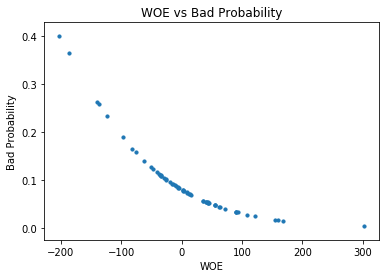

In [38]:
WOE_odds=WOE
WOE_odds["PROB"]=WOE_odds["BAD"]/(WOE_odds["BAD"]+WOE_odds["GOOD"])
plt.scatter(x=WOE_odds["WOE"], y=WOE_odds["PROB"], s=10);
plt.title("WOE vs Bad Probability")
plt.xlabel("WOE")
plt.ylabel("Bad Probability");

## Information Value

Information Value is a characteristic-level metric used to measure the "predictive strength" of the characteristic. 

For each of a characteristic's attribute, the difference between the Good and Bad population proportions is taken and multiplied by log odds; this is summed across attributes to give the characteristic-level figure. 

This calculation reconciles the signs (if population Good proportion> populaion Bad proportion then WOE>0, and vice versa) and then essentially weights each attribute's log odds by how "big" the attribute is in relation the dataset. 

In [39]:
IV=WOE[["Characteristic", "Attribute", "Dist_GOOD", "Dist_BAD", "ln_ODDS", "WOE"]]
IV["Dist_DIFF"]=IV["Dist_GOOD"]-IV["Dist_BAD"]
#"Margin Information Value" of each attribute
IV["Marg_IV"]=IV["Dist_DIFF"]*IV["ln_ODDS"]

In [40]:
IV.sort_values(by="Marg_IV", ascending=False).head()

,Characteristic,Attribute,Dist_GOOD,Dist_BAD,ln_ODDS,WOE,Dist_DIFF,Marg_IV
14,EXT_SOURCE_2_bins,0.0_0.1,0.030847,0.106546,-1.239537,-123.95,-0.075699,0.093832
21,EXT_SOURCE_2_bins,0.7_0.8,0.157464,0.061672,0.937375,93.74,0.095793,0.089794
31,EXT_SOURCE_3_bins,0.7_0.8,0.127191,0.051923,0.895916,89.59,0.075267,0.067433
25,EXT_SOURCE_3_bins,0.1_0.2,0.040596,0.107754,-0.976177,-97.62,-0.067158,0.065558
24,EXT_SOURCE_3_bins,0.0_0.1,0.013977,0.056878,-1.403524,-140.35,-0.042902,0.060213


In [41]:
IV.sort_values(by="Marg_IV", ascending=False).tail()

,Characteristic,Attribute,Dist_GOOD,Dist_BAD,ln_ODDS,WOE,Dist_DIFF,Marg_IV
51,REGION_RATING_CLIENT_W_CITY,2,0.747522,0.731923,0.021088,2.11,0.015599,0.000329
28,EXT_SOURCE_3_bins,0.4_0.5,0.119337,0.113756,0.047896,4.79,0.005581,0.000267
41,NAME_INCOME_TYPE,Maternity leave,0.000011,0.000081,-2.027020,-202.70,-0.000070,0.000142
36,NAME_EDUCATION_TYPE,Incomplete higher,0.033270,0.035126,-0.054278,-5.43,-0.001856,0.000101
23,EXT_SOURCE_2_bins,miss,0.002151,0.002095,0.026446,2.64,0.000056,0.000001


We can see that our external data sources are going to be doing a lot of the heavy lifting:

In [42]:
IV=WOE
IV["Dist_DIFF"]=IV["Dist_GOOD"]-IV["Dist_BAD"]
IV["Marg_IV"]=IV["Dist_DIFF"]*IV["ln_ODDS"]
IV=IV[["Characteristic", "Marg_IV"]].groupby("Characteristic").sum().rename(columns={"Marg_IV":"IV"})
IV.sort_values(by="IV", ascending=False).head(len(IV))

,IV
Characteristic,
EXT_SOURCE_3_bins,0.332873
EXT_SOURCE_2_bins,0.311565
EXT_SOURCE_1_bins,0.155855
YEARS_EMPLOYED_bins,0.108561
YEARS_OLD_bins,0.068896
NAME_INCOME_TYPE,0.058322
REGION_RATING_CLIENT_W_CITY,0.051201
NAME_EDUCATION_TYPE,0.050836
REGION_RATING_CLIENT,0.048317


## Scoring and Modelling

### Introduction

We can now  try scoring and modelling our attributes. 

Our objectives are:

1) To estimate bad probabilities to applicants which accurately reflect their actual probability of default.

2) To assign scores to attributes which, when summed by applicant, accurately reflect their estimated bad probability.  

3) To align the above with other operational considerations.

With regards to the last point, our main goal is to have a scoring and modelling scheme which can provide straightforward answers to the kind  of quesions which will commonly be asked of it: customers and operational staff need to know how a score was calculated; managers need to understand the underlying reasons behind portfolio-level trends and variations. 

An initial consideration is whether we want to use encoded binary variables or WOE values as our input data. if the latter, and we are using a modelling method which estimates characteristic-level paramters (such as logistic regression), then we can potentially calculate score by weighting log odds by the estimated parameter. 

We'll begin by trying some combinations to see how they fare in terms of our objectives. We'll then consider what other modelling methods such as decision trees, ensemble methods and boosting could bring to the table.  

### Odds Scoring

We'll set up our initial scores as a linear transformation of WOE, via some parmeters:

In [43]:
Score=WOE[["Characteristic", "Attribute", "ln_ODDS", "WOE"]]

#"Points to double odds" 
PDO=10

FACTOR=PDO/np.log(2)
print("Factor = " + str(FACTOR))
#Odds ratio and mid-point: odds at 20:1 for points=100 and doubling every 10 points
OR=20
MID=100
OFFSET=MID-FACTOR*np.log(OR)

print("Offset =  " + str(OFFSET))

Score["Odds Score"]=round(OFFSET+FACTOR*Score["ln_ODDS"], 2)

print("Mean score = " + str(np.mean(Score["Odds Score"])))

Factor = 14.426950408889635
Offset =  56.780719051126376
Mean score = 58.17129032258064


In [44]:
Score.sort_values(by="Odds Score", ascending=False).head()

,Characteristic,Attribute,ln_ODDS,WOE,Odds Score
57,YEARS_EMPLOYED_bins,40+,3.018553,301.86,100.33
12,EXT_SOURCE_1_bins,0.9_1.0,1.679649,167.96,81.01
22,EXT_SOURCE_2_bins,0.8_0.9,1.591079,159.11,79.74
34,NAME_EDUCATION_TYPE,Academic degree,1.550307,155.03,79.15
11,EXT_SOURCE_1_bins,0.8_0.9,1.222755,122.28,74.42


In [45]:
Score.sort_values(by="Odds Score", ascending=False).tail()

,Characteristic,Attribute,ln_ODDS,WOE,Odds Score
14,EXT_SOURCE_2_bins,0.0_0.1,-1.239537,-123.95,38.90
3,EXT_SOURCE_1_bins,0.0_0.1,-1.376674,-137.67,36.92
24,EXT_SOURCE_3_bins,0.0_0.1,-1.403524,-140.35,36.53
45,NAME_INCOME_TYPE,Unemployed,-1.872870,-187.29,29.76
41,NAME_INCOME_TYPE,Maternity leave,-2.027020,-202.70,27.54


Joining the above scores to subjects and plotting the distributions of Bads/Goods, we can see that our scoring system is behaving as expected, with a somewhat lower mean for Bad sbbjects. There is however greater overlap between the distributions than we might prefer:

Text(0.5,0,'Score')

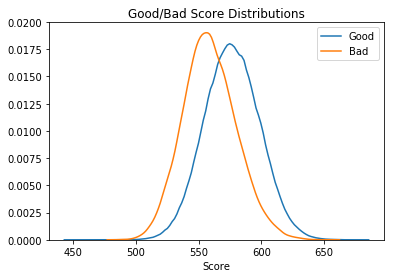

In [46]:
import seaborn as sns
Sub_Scores=pd.merge(IV_WOE, Score[["Odds Score", "Characteristic", "Attribute"]], on=["Characteristic", "Attribute"], how="left")
Sub_Scores_sum=pd.merge(Sub_Scores.drop(columns="Odds Score"), Sub_Scores[["index", "Odds Score"]].groupby("index").sum().reset_index(), on="index")[["index", "Odds Score", "TARGET"]].drop_duplicates().reset_index().drop(columns='level_0')

sns.kdeplot(Sub_Scores_sum.loc[Sub_Scores_sum['TARGET'] == 0, "Odds Score"], label = 'Good');
sns.kdeplot(Sub_Scores_sum.loc[Sub_Scores_sum['TARGET'] == 1, "Odds Score"], label = 'Bad');
plt.title("Good/Bad Score Distributions")
plt.xlabel("Score")

The most import measure of model success will to look at how well the model estimates bad probability. The purpose of a model is not good/bad decisioning (this is what the scorecard is for), or to predict if an existing customer is going to go bad (unless it is tracking balances, or some other external data source) since no successful applicants are going to be predicted bads at the outset. Rather, the model's main focus is going to be predicting portfolio outcomes. The number of expected bads in a portfolio will simply be calculated from the sum of bad probabilities. If more successful applicants go bad than expected, then this could have severely adverse business consequences; if fewer go bad then this means that the reject threshold was set too high, and that the organisation has not written as much business as it could have.

ROC-AUC will also be a useful metric. This measures how true positive rate varies with decision threshold, with an ROC-AUC score of 1 indicating that the model is insensitive to decision threshold and will identify true positives without also flagging lots of false positives. 

Precision and recall will also be useful: if the above are not good, these will indicate if this because we are overestimating or underestimating bad probabilities. 

Accuracy will not be very useful in this case because our bad rate is generally low (8%), so a decent accuracy score can be achieved without really doing anything. 

Creating a function to evaluate binary classifiers in this manner:

In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score

def binary_evaluation_metrics(X, y, model):

    y_proba=model.predict_proba(X)[:,1]
    y_pred=np.greater_equal(y_proba, 0.5).astype(int)
    recall=recall_score(y, y_pred)
    precision=precision_score(y, y_pred)
    roc_auc=roc_auc_score(y, y_proba)   
    
    print("ROC-AUC score: " + str(roc_auc))
    print("Precision: " + str(precision))
    print("Recall: " + str(recall))  

In [48]:
def estimated_actual_probability(X, y, model):
    
    df_data=np.array([[model.predict_proba(X)[:,1]], [y]])
    df=pd.DataFrame(df_data.squeeze().T, columns=['prob', 'actual'])
    prob_bounds=[x*0.05 for x in range(0, 20)]
    apply_bins(df, prob_bounds, "prob")

    df_probs=df.drop(columns='prob').groupby("prob_bins").mean().reset_index()
    df_probs.loc[df_probs.prob_bins=="0.95+","prob_bins"]="0.95_1.00"
    df_probs['mid']=np.mean([np.array(df_probs["prob_bins"].str.split('_', expand=True)[1]).astype(float),
                            np.array(df_probs["prob_bins"].str.split('_', expand=True)[0]).astype(float)], axis=0)

    df_probs=df_probs.sort_values('mid', ascending=True)
    plt.figure(figsize=(10,5))

    plt.scatter(df_probs["mid"], df_probs["actual"])
    plt.plot([x*0.05 for x in range(0, 20)], [x*0.05 for x in range(0, 20)], label="45 degree")
    plt.title("Estimated vs Actual Probability")
    plt.xlabel("estimated probability")
    plt.ylabel("actual probability")
    plt.legend()

Creating training data:

In [49]:
y_train=IV_WOE_data.TARGET
X_train_binary=pd.get_dummies(IV_WOE_data.drop(columns=['index', 'TARGET']))


Testing:

ROC-AUC score: 0.7367752628844237
Precision: 0.503921568627451
Recall: 0.010352467270896275


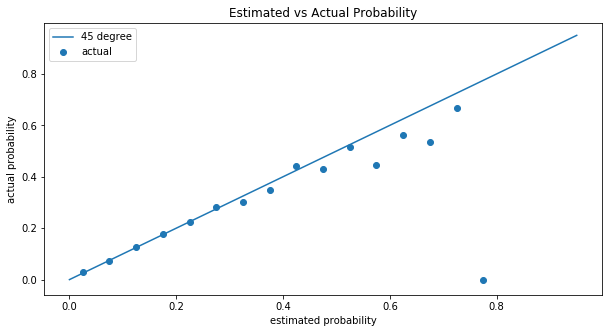

In [50]:
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression()
log_reg.fit(X_train_binary, y_train)
binary_evaluation_metrics(X_train_binary, y_train, log_reg)
estimated_actual_probability(X_train_binary, y_train, log_reg)

The ROC-AUC score is not particularly good in this case. The precision and recall metrics indicate that the model is only identifying bad in very "clear-cut" cases. I.e, it is generally underestimating bad probability. 

Checking against our second objective - the performance of the scores themselves - the strong linear curve seen below shows that our scores are reflective of underlying rates. The exception to this is at the lowest value, but this seems to be due to the small number of subjects having this score:

Score-Odds MSE = 0.050513379009864856


Text(0.5,0,'Score')

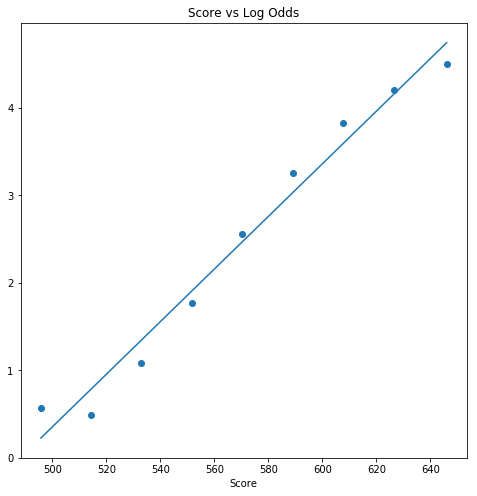

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Sub_Scores_bins=Sub_Scores_sum  
score_bounds=[x*20 for x in range(22, 45)]
apply_bins(Sub_Scores_bins, score_bounds, "Odds Score")
Sub_Scores_bins.head()
Sub_Scores_totals=Sub_Scores_bins[["Odds Score_bins", "TARGET"]].groupby("Odds Score_bins").agg(['sum', 'count']).reset_index()
Sub_Scores_totals.columns=['bins','bad', 'count']
Sub_Scores_totals['good']=Sub_Scores_totals['count']-Sub_Scores_totals['bad']
Sub_Scores_totals['log odds']=np.log(Sub_Scores_totals['good']/Sub_Scores_totals['bad'])
Sub_Scores_totals=pd.merge(Sub_Scores_totals, 
                           Sub_Scores_bins[["Odds Score_bins", "Odds Score"]].groupby("Odds Score_bins").mean().reset_index(),
                           left_on="bins", right_on="Odds Score_bins", how="left").rename(columns={"Odds Score": "mean score"})
Sub_Scores_totals=Sub_Scores_totals.replace(np.inf, np.nan).dropna()
lr=LinearRegression()
pd.merge(Sub_Scores_totals, Sub_Scores_bins[["Odds Score_bins", "Odds Score"]].groupby("Odds Score_bins").mean().reset_index(), 
         left_on="bins", right_on="Odds Score_bins", how="left")
lr.fit(np.array(Sub_Scores_totals['mean score']).reshape(-1, 1), Sub_Scores_totals['log odds'])
y_pred=lr.predict(Sub_Scores_totals['mean score'].reshape(-1, 1))
mse=mean_squared_error(y_pred, Sub_Scores_totals['log odds'])
print("Score-Odds MSE = " + str(mse))
plt.figure(figsize=(8,8))
plt.scatter(Sub_Scores_totals['mean score'], Sub_Scores_totals['log odds'])
plt.plot(Sub_Scores_totals['mean score'], y_pred)
plt.title("Score vs Log Odds")
plt.xlabel("Score")

What are the advantages of such a setup?

For one thing, it is very easy to understand and communicate how the scores have been calculated; they can be understood in laymans terms as measuring "how much more likely you are to default on your credit". 

Furthermore, the scores are quite reflective of actual performance: the scoring system could be used for acceptance/rejection decisioning with a reasonable degree of confidence. 

The actual model is underperforming, but it is worth keeping in mind that we did not set up our input features to give the best possible performance, so what will matter here is how it performs relative to other models. 

### WOE Input Data

As mentioned above, our other option with regards input data is to use attribute WOE figures, rather than binomials. Is there any advantage to this?

In [80]:
# Joining attribute WOE at subject level
subject_woe=pd.merge(IV_WOE,WOE , on=["Characteristic", "Attribute"], how="left")
train_woe=pd.merge(subject_woe.drop(columns="Attribute").pivot(index='index', columns='Characteristic', values='WOE').reset_index(), 
               subject_woe[["index", "TARGET"]].drop_duplicates(), on='index', how='left').dropna()



X_train_woe=train_woe.drop(columns=["TARGET", "index"])
y_train_woe=train_woe.TARGET

In [81]:
X_train_woe.head()

,CODE_GENDER,EXT_SOURCE_1_bins,EXT_SOURCE_2_bins,EXT_SOURCE_3_bins,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,YEARS_EMPLOYED_bins,YEARS_OLD_bins
0,-25.09,-137.67,-47.70,-97.62,-11.15,-18.87,2.50,2.11,-29.72,-34.82
1,15.43,-13.51,45.70,-15.64,43.96,36.33,55.04,54.60,-29.72,-4.49
2,-25.09,-5.87,12.29,89.59,-11.15,-18.87,2.50,2.11,-29.72,-4.49
3,15.43,-5.87,45.70,-15.64,-11.15,-18.87,2.50,2.11,9.81,-4.49
4,-25.09,-5.87,-33.55,-15.64,-11.15,-18.87,2.50,2.11,9.81,42.16


Testing the model:

In [82]:
log_reg.fit(X_train_woe, y_train_woe)
binary_evaluation_metrics(X_train_woe, y_train_woe, log_reg)

ROC-AUC score: 0.7346762036043184
Precision: 0.4575342465753425
Recall: 0.006727089627391742


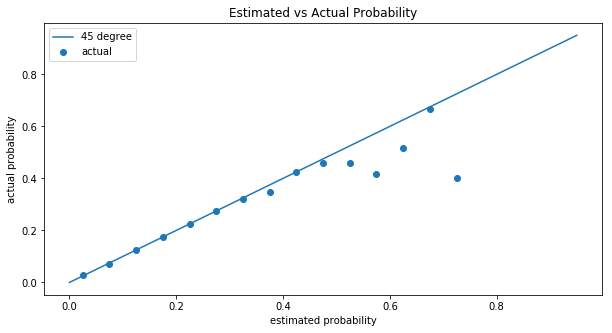

In [83]:
estimated_actual_probability(X_train_woe, y_train_woe, log_reg)


This has made virtually no difference to model performance. Using WOE values as opposed to binominals is supposed to assist training by capturing value differences between bins. However, at least in our case, this hasn't had any effect on performance. 

Another potential benefit of using WOE values as input data is that the estimated regression parameters can then be used to inform the scorecard. This might improve scorecard performance, and would also give a stronger manthematical relationship between the scorecard and the model, which would have the operational benefit of guaranteeing that portfolio-level variations in particular variables would be visible in both by necessity, and both would reflect the new risk environment. 

Parameter-weighted "logistic scores" are calculated below:

In [84]:
weights=log_reg.coef_
intercept=log_reg.intercept_
Weights=pd.DataFrame(np.vstack((weights.squeeze(), X_train_woe.columns)).T, columns=["Weight", "Characteristic"])
weights

array([[-0.00538435, -0.00549634, -0.00787932, -0.00866861, -0.00725436,
        -0.0037267 ,  0.0026899 , -0.00624951, -0.00510121,  0.00130996]])

Text(0.5,0,'Score')

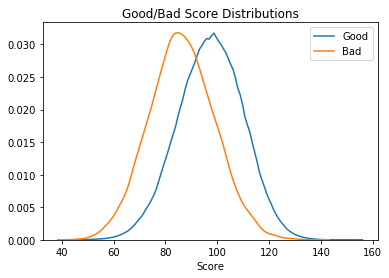

In [85]:
Score=WOE[["Characteristic", "Attribute", "ln_ODDS", "WOE"]]
Score=pd.merge(Score, Weights, on="Characteristic", how="left")
Score["Logistic_Score"]=-(Score["WOE"]*Score["Weight"]+(intercept/len(Weights)))*FACTOR+(OFFSET/len(Weights))
Sub_Scores=pd.merge(IV_WOE, Score[["Logistic_Score", "Characteristic", "Attribute"]], on=["Characteristic", "Attribute"], how="left")
Sub_Scores_sum=pd.merge(Sub_Scores.drop(columns="Logistic_Score"), Sub_Scores[["index", "Logistic_Score"]].groupby("index").sum().reset_index(), on="index")[["index", "Logistic_Score", "TARGET"]].drop_duplicates().reset_index().drop(columns='level_0')
Sub_Scores_sum.head()

sns.kdeplot(Sub_Scores_sum.loc[Sub_Scores_sum['TARGET'] == 0, "Logistic_Score"], label = 'Good');
sns.kdeplot(Sub_Scores_sum.loc[Sub_Scores_sum['TARGET'] == 1, "Logistic_Score"], label = 'Bad');
plt.title("Good/Bad Score Distributions")
plt.xlabel("Score")

The new scores are behaving as one would expect. Comparing to log-odds:

Score-Odds MSE = 0.012386303640262475


Text(0,0.5,'log odds')

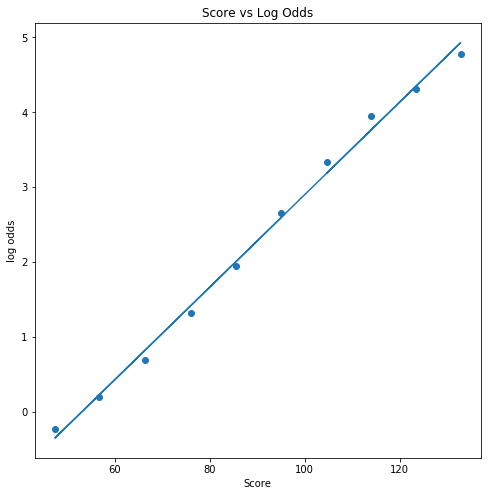

In [86]:
Sub_Scores_bins=Sub_Scores_sum
Sub_Scores_sum.head(30)
score_bounds=[x*10 for x in range(4, 15)]
apply_bins(Sub_Scores_bins, score_bounds, "Logistic_Score")
Sub_Scores_bins.head()
Sub_Scores_totals=Sub_Scores_bins[["Logistic_Score_bins", "TARGET"]].groupby("Logistic_Score_bins").agg(['sum', 'count'])
Sub_Scores_totals.columns=['bad', 'count']
Sub_Scores_totals['good']=Sub_Scores_totals['count']-Sub_Scores_totals['bad']

Sub_Scores_totals['log odds']=np.log(Sub_Scores_totals['good']/Sub_Scores_totals['bad'])
Sub_Scores_totals['mean score']=Sub_Scores_bins[["Logistic_Score_bins", "Logistic_Score"]].groupby("Logistic_Score_bins").mean()

Sub_Scores_totals=Sub_Scores_totals.replace(np.inf, np.nan).dropna()
lr=LinearRegression()
lr.fit(np.array(Sub_Scores_totals['mean score']).reshape(-1, 1), Sub_Scores_totals['log odds'])
y_pred=lr.predict(Sub_Scores_totals['mean score'].reshape(-1, 1))
mse=mean_squared_error(y_pred, Sub_Scores_totals['log odds'])
print("Score-Odds MSE = " + str(mse))
plt.figure(figsize=(8,8))
plt.scatter(Sub_Scores_totals['mean score'], Sub_Scores_totals['log odds'])
plt.plot(Sub_Scores_totals['mean score'], y_pred)
plt.title("Score vs Log Odds")
plt.xlabel("Score")
plt.ylabel("log odds")

This actually looks to have improved the scorecard quite a bit. Combining the model and the scorecard in this way seems to have produced a tool that is greater than the sum of its parts and would be useful operationally for both customer management and portfolio-level analytics. 

### Decision Trees

We'll now examine a few machine learning approaches to classification to see how they perform and interact with the scorecard. 

We'll start with Decision Trees. These work by examining every input feature and finding a value of a feature which gives the neatest bad/good split. This process is then iterated up to a procedurally or hyperparameter-determined end point. Crucially, it serves our purposes in that it produces prediction probabilities, by taking the bad proportion in the end-node (leaf) each observation ends up in. 

We'll try it on both WOE and binary data and see how it performs. We'll tune the models using the method of early stopping, which iteratively increases fitting until it stops yielding benefits to mean squared error. Checking WOE input data first:

max depth = 24
ROC-AUC score: 0.9026837909590817
Precision: 0.7222274568924903
Recall: 0.30876132930513595


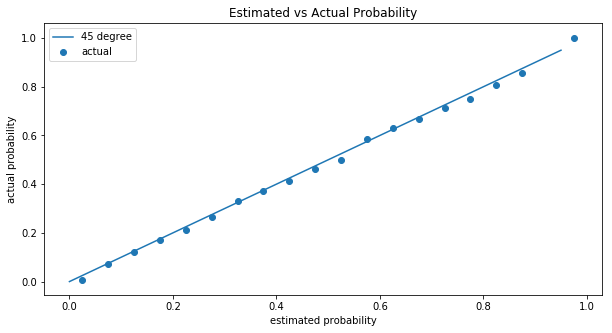

In [87]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

def tree_early_stopping(X, y):
    i=1
    j=1
    min_score=float('inf')
    while True:
        i=i+1
        tree=DecisionTreeClassifier(max_depth=i)     
        tree.fit(X, y)
        mean_score=np.mean(cross_val_score(tree, X, y, cv=3))
        if mean_score<=min_score:
            min_score=mean_score
        else: j=j+1
        if j>=5:
            print("max depth = " + str(i-j))
            tree=DecisionTreeClassifier(max_depth=i-j)     
            tree.fit(X, y)
            break
    
    binary_evaluation_metrics(X, y, tree)
    estimated_actual_probability(X, y, tree)
    
tree_early_stopping(X_train_woe, y_train_woe)

This model is performing quite a lot better than the logistic model. It is producing prediction probabilities that are quite a bit more accurate, and this is reflected in both the ROC-AUC score and the estimated vs actual probabilities plot.

Since all our WOE features have linear (or at least convex) relationships with bad probability, all the bad probabilities produced by the decision tree to be linear combinations of the underlying WOE values.This is good, because changes in the underlying risk environment will be reflected in model's predictions, and vice versa. However, selecting and creating variables in this way has most likely held the model back somewhat. A decision tree will essentially slice the test set into discrete areas of feature space, allowing to exploit local relationships which a logistic model would not be able to find. So the setup we have here seems to be the best way of using decision trees in a business context: otherwise, the model is likely to behave somewhat opaquely, prompting awkward questions for credit risk managers. 

Another point of departure is that the logistic regression model served the scorecard by weighting each score by the slope of its linear relationship to bad probability. Relationships with regards decision trees are not so clear-cut; however, it does produce a characteristic-level "feature importance" metric, which measure the extent to which that feature has been used to perform splits. Might this be used, in place of logistic regression parameter, to weight scores?

The below examines this. We can see that it does have marginal benefit to scorecard (the MSE of the score/odds regression has dropped from around 0.05 to 0.04):

Factor = 14.426950408889635


Text(0.5,0,'Score')

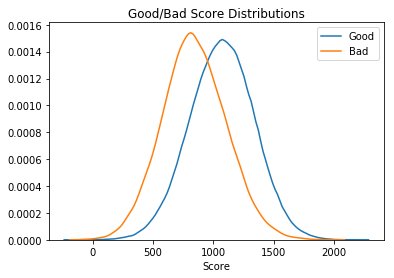

In [88]:
tree=DecisionTreeClassifier(max_depth=27)     
tree.fit(X_train_woe, y_train_woe)

#"Points to double odds" 
PDO=10

FACTOR=PDO/np.log(2)
print("Factor = " + str(FACTOR))
#Odds ratio and mid-point: odds at 20:1 for points=100 and doubling every 10 points
OR=20
MID=1000
OFFSET=MID-FACTOR*np.log(OR)

weights= tree.feature_importances_
Weights=pd.DataFrame(np.vstack((weights.squeeze(), X_train_woe.columns)).T, columns=["Weight", "Characteristic"])
Score=WOE[["Characteristic", "Attribute", "ln_ODDS", "WOE"]]
Score=pd.merge(Score, Weights, on="Characteristic", how="left")
Score["Logistic_Score"]=(Score["WOE"]*Score["Weight"])*FACTOR+(OFFSET/len(Weights))
Sub_Scores=pd.merge(IV_WOE, Score[["Logistic_Score", "Characteristic", "Attribute"]], on=["Characteristic", "Attribute"], how="left")
Sub_Scores_sum=pd.merge(Sub_Scores.drop(columns="Logistic_Score"), Sub_Scores[["index", "Logistic_Score"]].groupby("index").sum().reset_index(), on="index")[["index", "Logistic_Score", "TARGET"]].drop_duplicates().reset_index().drop(columns='level_0')
# Sub_Scores_sum.head()

sns.kdeplot(Sub_Scores_sum.loc[Sub_Scores_sum['TARGET'] == 0, "Logistic_Score"], label = 'Good');
sns.kdeplot(Sub_Scores_sum.loc[Sub_Scores_sum['TARGET'] == 1, "Logistic_Score"], label = 'Bad');
plt.title("Good/Bad Score Distributions")
plt.xlabel("Score")
# Score

Score-Odds MSE = 0.040757498731466536


Text(0,0.5,'log odds')

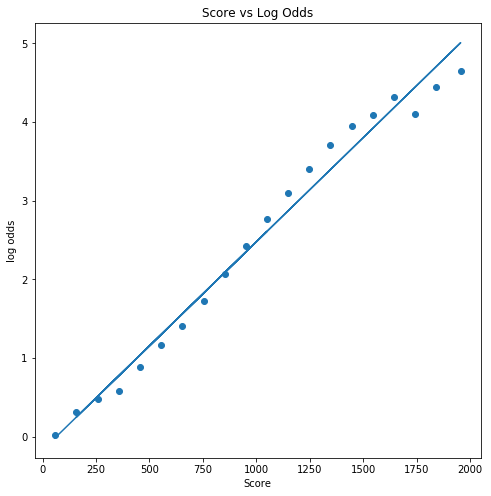

In [89]:
Sub_Scores_bins=Sub_Scores_sum  
score_bounds=[x*100 for x in range(0, 20)]
apply_bins(Sub_Scores_bins, score_bounds, "Logistic_Score")
Sub_Scores_totals=Sub_Scores_bins[["Logistic_Score_bins", "TARGET"]].groupby("Logistic_Score_bins").agg(['sum', 'count'])
Sub_Scores_totals.columns=['bad', 'count']
Sub_Scores_totals['good']=Sub_Scores_totals['count']-Sub_Scores_totals['bad']

Sub_Scores_totals['log odds']=np.log(Sub_Scores_totals['good']/Sub_Scores_totals['bad'])
Sub_Scores_totals['mean score']=Sub_Scores_bins[["Logistic_Score_bins", "Logistic_Score"]].groupby("Logistic_Score_bins").mean()
Sub_Scores_totals=Sub_Scores_totals.replace(np.inf, np.nan).dropna()
lr=LinearRegression()
# Sub_Scores_totals
lr.fit(np.array(Sub_Scores_totals['mean score']).reshape(-1, 1), Sub_Scores_totals['log odds'])
y_pred=lr.predict(Sub_Scores_totals['mean score'].reshape(-1, 1))
mse=mean_squared_error(y_pred, Sub_Scores_totals['log odds'])
print("Score-Odds MSE = " + str(mse))
plt.figure(figsize=(8,8))
plt.scatter(Sub_Scores_totals['mean score'], Sub_Scores_totals['log odds'])
plt.plot(Sub_Scores_totals['mean score'], y_pred)
plt.title("Score vs Log Odds")
plt.xlabel("Score")
plt.ylabel("log odds")


How does a business manage a situaton in which the scorecard is underperforming, and the model performing well? 

A compromise could be to use logistic regression to inform the scorecard, but use decision trees, or other high-performing machine learning algorithms, for portfolio-level risk prediction. This situation would become difficult to manage if th predictions of the models began to diverge, however this should not happen so long as the models use the same sets of linear input data. 

We'll also test the performance of decision trees using binomial input data, for the sake of tying things off. Note that this approach does not allow us to apply feature importance to the scorecard:

max depth = 31
ROC-AUC score: 0.9004935471587016
Precision: 0.7213812677388837
Recall: 0.3071500503524673


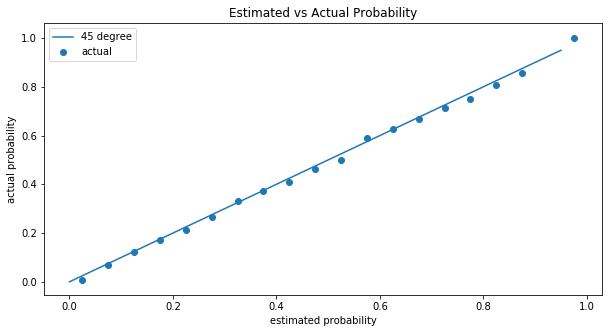

In [90]:
tree_early_stopping(X_train_binary, y_train)

As we've come to expect, performance is roughly the same.  

### Ensemble Methods

Random forests work by creating a large number of decision trees on subsets of the data and then taking averages. Examining performance:

n_estimators = 12
ROC-AUC score: 0.8907227489979511
Precision: 0.7835369774919614
Recall: 0.2453977844914401


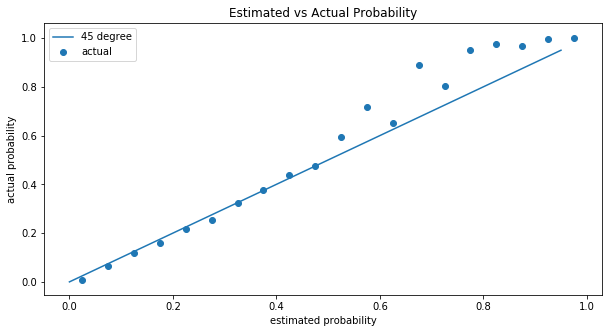

In [92]:
from sklearn.ensemble import RandomForestClassifier

def forest_early_stopping(X, y):
    #starting at 10 estimators, to prevent premature stopping due to statistical noise
    i=10
    j=1
    min_score=float('inf')
    while True:
        i=i+1
        rf=RandomForestClassifier(n_estimators =i)     
        rf.fit(X, y)
        mean_score=np.mean(cross_val_score(tree, X, y, cv=9))
        if mean_score<=min_score:
            min_score=mean_score
        else: j=j+1
        if j>=5:
            rf=RandomForestClassifier(n_estimators =i-j)
            print("n_estimators = " + str(i-j))
            rf.fit(X, y)
            break
    
    binary_evaluation_metrics(X, y, rf)
    estimated_actual_probability(X, y, rf)

forest_early_stopping(X_train_woe, y_train_woe)

The algorithm is working quite well as a classifier in terms of precision and recall, however it is not faring as well as decision trees for our purposes since it's ROC-AUC score is not as high. Beyond 50% actual/estimated probability, it begins to underestimate probability

The benefits of applying calculated feature importance weights to the scorecard are marginal and similar to decision trees:  

Factor = 14.426950408889635
Score-Odds MSE = 0.03932491368893843


Text(0,0.5,'log odds')

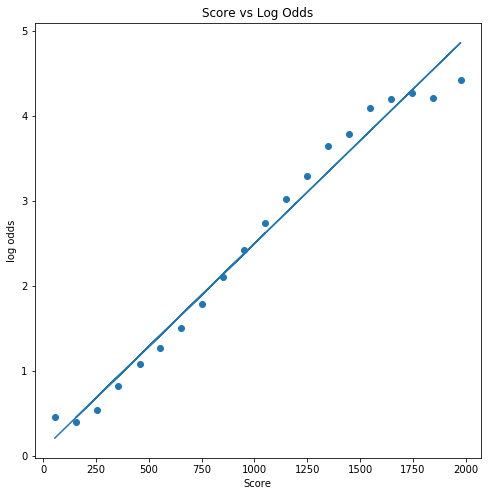

In [95]:
rf=RandomForestClassifier(n_estimators =12)
rf.fit(X_train_woe, y_train_woe)

#"Points to double odds" 
PDO=10
FACTOR=PDO/np.log(2)
print("Factor = " + str(FACTOR))
#Odds ratio and mid-point: odds at 20:1 for points=100 and doubling every 10 points
OR=20
MID=1000
OFFSET=MID-FACTOR*np.log(OR)

weights= rf.feature_importances_
Weights=pd.DataFrame(np.vstack((weights.squeeze(), X_train_woe.columns)).T, columns=["Weight", "Characteristic"])
Score=WOE[["Characteristic", "Attribute", "ln_ODDS", "WOE"]]
Score=pd.merge(Score, Weights, on="Characteristic", how="left")
Score["Logistic_Score"]=(Score["WOE"]*Score["Weight"])*FACTOR+(OFFSET/len(Weights))
Sub_Scores=pd.merge(IV_WOE, Score[["Logistic_Score", "Characteristic", "Attribute"]], on=["Characteristic", "Attribute"], how="left")
Sub_Scores_sum=pd.merge(Sub_Scores.drop(columns="Logistic_Score"), Sub_Scores[["index", "Logistic_Score"]].groupby("index").sum().reset_index(), on="index")[["index", "Logistic_Score", "TARGET"]].drop_duplicates().reset_index().drop(columns='level_0')

Sub_Scores_bins=Sub_Scores_sum  
score_bounds=[x*100 for x in range(0, 20)]
apply_bins(Sub_Scores_bins, score_bounds, "Logistic_Score")
Sub_Scores_totals=Sub_Scores_bins[["Logistic_Score_bins", "TARGET"]].groupby("Logistic_Score_bins").agg(['sum', 'count'])
Sub_Scores_totals.columns=['bad', 'count']
Sub_Scores_totals['good']=Sub_Scores_totals['count']-Sub_Scores_totals['bad']

Sub_Scores_totals['log odds']=np.log(Sub_Scores_totals['good']/Sub_Scores_totals['bad'])
Sub_Scores_totals['mean score']=Sub_Scores_bins[["Logistic_Score_bins", "Logistic_Score"]].groupby("Logistic_Score_bins").mean()
Sub_Scores_totals=Sub_Scores_totals.replace(np.inf, np.nan).dropna()
lr=LinearRegression()
# Sub_Scores_totals
lr.fit(np.array(Sub_Scores_totals['mean score']).reshape(-1, 1), Sub_Scores_totals['log odds'])
y_pred=lr.predict(Sub_Scores_totals['mean score'].reshape(-1, 1))
mse=mean_squared_error(y_pred, Sub_Scores_totals['log odds'])
print("Score-Odds MSE = " + str(mse))
plt.figure(figsize=(8,8))
plt.scatter(Sub_Scores_totals['mean score'], Sub_Scores_totals['log odds'])
plt.plot(Sub_Scores_totals['mean score'], y_pred)
plt.title("Score vs Log Odds")
plt.xlabel("Score")
plt.ylabel("log odds")

AdaBoost, which works by iterative training classifiers on residiual error, performs in a similar, though more extremely, way to random forest. It's ROC-AUC score is comparable to the decision tree and random forest models. 

The probability estimates it produces are interesting. Essentially, it has only produced estimates greater than 60% or so  for observations which were in fact bads. So it is working very well as a classifier, but does not actually produce reflective probabilities. 

AdBoostClassifier doesn't produce feature importance weights:

ROC-AUC score: 0.9040995697870545
Precision: 0.8108108108108109
Recall: 0.24894259818731118


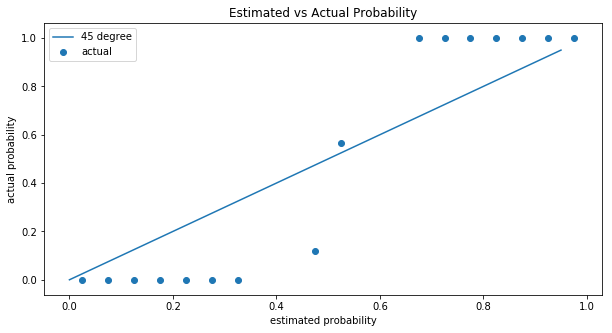

In [96]:
from sklearn.ensemble import AdaBoostClassifier
ad=AdaBoostClassifier(DecisionTreeClassifier(max_depth=40),n_estimators=200, learning_rate=0.5)

ad.fit(X_train_woe, y_train_woe)
binary_evaluation_metrics(X_train_woe, y_train_woe, ad)
estimated_actual_probability(X_train_woe, y_train_woe, ad)

## Conclusion

In light of what we've seen, there doesn't seem to be a stong case for foregoing the benefits to scorecard performance afforded by logistic regression. Decision Trees do appear as though they could have a role in the process in performing portfolio modelling, although strong consideration needs to be given to how they are set up to ensure that there is no informational disjunct between the model and the scorecard. The ensemble based methods we have seen appear to perform outstandingly as classifiers and have obvious applications in other contexts, but aren't set up for probability estimation and hence aren't suitbale for our purposes. 

We still haven't got the best out of these models for this project given the data that is available. Next time, we'll see if dimensionality reduction and feature engineering can bring us to closer to identifying the "kinds" of customers likely to default. 